In [1]:
import numpy as np
import matplotlib.pyplot as plt
import zarr
import xarray as xr
import os
import torch

In [2]:
%matplotlib inline

## Initialize the data and save it in training, validation, and test data sets

In [3]:
onecatfile = 'offline_singlecat_referencedetail.nc'
twocatfile = 'offline_79micron_referencedetail.nc'

In [4]:
onecatfilepath=os.path.join('/home/jovyan/neural-dsds/neural-dsds/data',onecatfile)
twocatfilepath = os.path.join('/home/jovyan/neural-dsds/neural-dsds/data',twocatfile)

In [5]:
from netCDF4 import Dataset
ds1 = Dataset(onecatfilepath)
ds2 = Dataset(twocatfilepath)

In [6]:
ds2

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): altitude(20), time(721), cloud_moment(3), rain_moment(3), case(16), bin_mass(35), bin_edge_mass(36)
    variables(dimensions): float64 altitude(altitude), float64 time(time), int32 cloud_moment(cloud_moment), int32 rain_moment(rain_moment), float64 bin_mass(bin_mass), float64 bin_edge_mass(bin_edge_mass), float64 nccn(case), float64 rhinit(case), float64 lhflux(case), float64 ampw(case), float64 tperiod(case), float64 pressure(case, altitude), float64 theta(case, time, altitude), float64 rel_hum(case, time, altitude), float64 cliq_mom(case, cloud_moment, time, altitude), float64 rain_mom(case, rain_moment, time, altitude), float64 cliq_mom_flux(case, cloud_moment, time), float64 rain_mom_flux(case, rain_moment, time), float64 cliq_path(case, time), float64 rain_path(case, time), float64 act(case, cloud_moment, time, altitude), float64 csed(case, cloud_moment, time, altitude), fl

In [7]:
from utils_data import flaggeddatanormed, logrescale, singlecatdata, masksinglecat, rescalesinglecat, bindatanormed, twocatdata

In [8]:
### Bin Data ###
M,dMdt,bin0,bin1coal,bin1condevap,binmagscales,binmag,M1,dM1dt,M2,dM2dt = flaggeddatanormed(ds1,ds2)

/home/jovyan/neural-dsd/utils_data.py:231: RuntimeWarning: invalid value encountered in divide
  dMdtsign[:,c,j]=dMdt[:,c,j]/np.abs(dMdt[:,c,j])


 Few drops:  35027.0
+ Low mass:  37737.0
+ Really Low Moments and neg. process rates:  52528.0
(230080, 35)
(230080,)
normalized


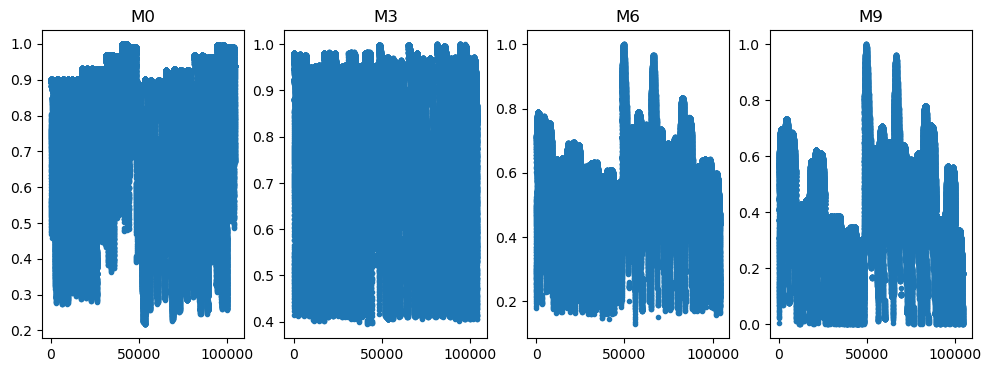

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
single_moms = ['M0','M3','M6','M9']
mom = 0

for j in range(0,4):
    ax[j].plot(M[:,j,1],'.')

    ax[j].set_title(single_moms[j])

In [10]:
bs = 500
quart = int(M.shape[0]/bs/4)

idx = np.arange(0,M.shape[0])
np.random.seed(42)
np.random.shuffle(idx)
trainidx = idx[0:bs*quart*2]
validx = idx[bs*quart*2:bs*quart*3]
testidx = idx[bs*quart*3:]
print("train ",trainidx[0],trainidx[-1],"val ",validx[0],validx[-1],"test ",testidx[0],testidx[-1])

train  90383 49279 val  102798 6180 test  20826 15795


In [11]:
M_train,dMdt_train = M[trainidx,:],dMdt[trainidx,:]
M_val,dMdt_val = M[validx,:],dMdt[validx,:]
M_test,dMdt_test = M[testidx,:],dMdt[testidx,:]

binmag_train = binmag[trainidx,:]
binmag_val = binmag[validx,:]
binmag_test = binmag[testidx,:]

bin0_train,bin1coal_train,bin1condevap_train = bin0[trainidx,:],bin1coal[trainidx,:],bin1condevap[trainidx,:]
bin0_val,bin1coal_val,bin1condevap_val = bin0[validx,:],bin1coal[validx,:],bin1condevap[validx,:]
bin0_test,bin1coal_test,bin1condevap_test = bin0[testidx,:],bin1coal[testidx,:],bin1condevap[testidx,:]

M1_train,dM1dt_train = M1[trainidx,:],dM1dt[trainidx,:]
M1_val,dM1dt_val = M1[validx,:],dM1dt[validx,:]
M1_test,dM1dt_test = M1[testidx,:],dM1dt[testidx,:]

M2_train,dM2dt_train = M2[trainidx,:],dM2dt[trainidx,:]
M2_val,dM2dt_val = M2[validx,:],dM2dt[validx,:]
M2_test,dM2dt_test = M2[testidx,:],dM2dt[testidx,:]

In [12]:
print(M_train.shape,dMdt_train.shape,bin0_train.shape,bin1coal_train.shape,bin1condevap_train.shape)
print(M_val.shape,dMdt_val.shape,bin0_val.shape,bin1coal_val.shape,bin1condevap_val.shape)
print(M_test.shape,dMdt_test.shape,bin0_test.shape,bin1coal_test.shape,bin1condevap_test.shape)
print(binmag_train.shape,binmag_val.shape,binmag_test.shape)

(52000, 4, 3) (52000, 4, 3) (52000, 2, 35) (52000, 2, 35) (52000, 2, 35)
(26000, 4, 3) (26000, 4, 3) (26000, 2, 35) (26000, 2, 35) (26000, 2, 35)
(26214, 4, 3) (26214, 4, 3) (26214, 2, 35) (26214, 2, 35) (26214, 2, 35)
(52000, 6) (26000, 6) (26214, 6)


In [13]:
from torch.utils.data import Dataset, DataLoader

In [14]:
class DriverDatasets(Dataset):
    def __init__(self,purpose,latent=False):

        if purpose == "train":
            self.M = M_train
            self.dMdt = dMdt_train
            self.M1 = M1_train
            self.dM1dt = dM1dt_train
            self.M2 = M2_train
            self.dM2dt = dM2dt_train         
            self.bin0 = bin0_train
            self.bin1coal = bin1coal_train
            self.bin1condevap = bin1condevap_train
            self.binmag = binmag_train
        elif purpose == "val":
            self.M = M_val
            self.dMdt = dMdt_val
            self.M1 = M1_val
            self.dM1dt = dM1dt_val
            self.M2 = M2_val
            self.dM2dt = dM2dt_val  
            
            self.bin0 = bin0_val
            self.bin1coal = bin1coal_val
            self.bin1condevap = bin1condevap_val
            self.binmag = binmag_val
        else:
            self.M = M_test
            self.dMdt = dMdt_test
            
            self.M1 = M1_test
            self.dM1dt = dM1dt_test
            self.M2 = M2_test
            self.dM2dt = dM2dt_test  
 
            self.bin0 = bin0_test
            self.bin1coal = bin1coal_test
            self.bin1condevap = bin1condevap_test
            self.binmag = binmag_test
    def __len__(self):
        return int(self.M.shape[0])
    def __getitem__(self,idx):

        idx0 = idx

        M = self.M[idx0,:]
        dMdt = self.dMdt[idx0,:]
        bin0 = self.bin0[idx0,:,:]
        bin1coal = self.bin1coal[idx0,:,:]
        bin1condevap = self.bin1condevap[idx0,:]
        binmag = self.binmag[idx0,:]
        
        M1 = self.M1[idx0,:]
        dM1dt = self.dM1dt[idx0,:]
        M2 = self.M2[idx0,:]
        dM2dt = self.dM2dt[idx0,:]        
        
        return M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt

In [15]:
traindataset = DriverDatasets("train")
valdataset = DriverDatasets("val")
testdataset = DriverDatasets("test")

In [16]:
bs = 500
trainloader = DataLoader(traindataset, batch_size=bs, shuffle=True)
valloader = DataLoader(valdataset, batch_size=bs, shuffle=True)
testloader = DataLoader(testdataset, batch_size=bs, shuffle=True)

In [16]:
# Save the DataLoaders
torch.save(trainloader,"data/trainloader_onecat.pth")
torch.save(valloader,"data/valloader_onecat.pth")
torch.save(testloader,"data/testloader_onecat.pth")

## Initialize the data for 1 case and save it without reshuffling

In [17]:
from utils_data import flaggeddatanormedcase

In [18]:
### Bin Data ###
case = 15
M,dMdt,bin0,bin1coal,bin1condevap,momscales,binmag,M1,dM1dt,M2,dM2dt,maskall = flaggeddatanormedcase(ds1,ds2,case,binmagscales)

/home/jovyan/neural-dsd/utils_data.py:231: RuntimeWarning: invalid value encountered in divide
  dMdtsign[:,c,j]=dMdt[:,c,j]/np.abs(dMdt[:,c,j])


 Few drops:  4768.0
+ Low mass:  5116.0
+ Really Low Moments and neg. process rates:  5116.0
(14380, 35)
(14380,)
normalized


/home/jovyan/neural-dsd/utils_data.py:729: RuntimeWarning: divide by zero encountered in log
  binmag[:,i] = np.log(binmag[:,i])


In [103]:
class DriverDatasetCase(Dataset):
    def __init__(self,latent=False):
            self.M = M
            self.dMdt = dMdt
            self.M1 = M1
            self.dM1dt = dM1dt
            self.M2 = M2
            self.dM2dt = dM2dt      
            self.bin0 = bin0
            self.bin1coal = bin1coal
            self.bin1condevap = bin1condevap
            self.binmag = binmag
            self.maskall = maskall
    def __len__(self):
        return int(self.M.shape[0])
    def __getitem__(self,idx):

        idx0 = idx

        M = self.M[idx0,:]
        dMdt = self.dMdt[idx0,:]
        bin0 = self.bin0[idx0,:,:]
        bin1coal = self.bin1coal[idx0,:,:]
        bin1condevap = self.bin1condevap[idx0,:]
        binmag = self.binmag[idx0,:]
        
        M1 = self.M1[idx0,:]
        dM1dt = self.dM1dt[idx0,:]
        M2 = self.M2[idx0,:]
        dM2dt = self.dM2dt[idx0,:]        
        
        return M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt

In [104]:
casedataset = DriverDatasetCase()
caseloader = DataLoader(casedataset, batch_size=bs, shuffle=False)

In [105]:
np.save("data/case"+str(case)+"mask.npy",maskall)

In [106]:
torch.save(caseloader,"data/case"+str(case)+"loader.pth")

## Two category normalized process rates (rather than single category)

In [17]:
### Bin Data ###
M,dMdt,bin0,bin1coal,bin1condevap,binmagscales,binmag,M1,dM1dt,M2,dM2dt = flaggeddatanormed(ds1,ds2,twocat=True)

(230080,)
 Few drops:  35746.0
+ Low mass:  38452.0
+ Really Low Moments:  105018.0
(230080, 35)
(230080,)
normalized


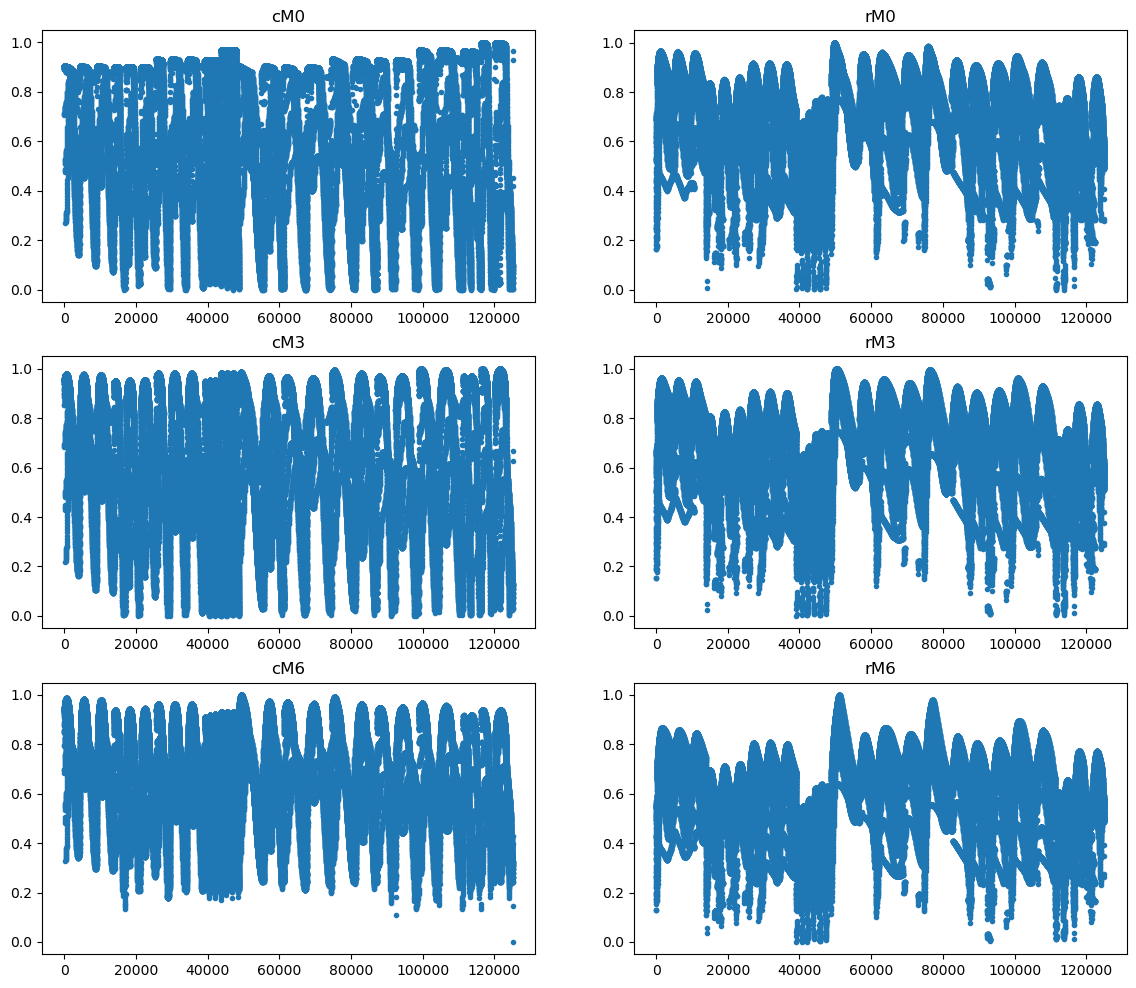

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14,12))
cloud_moms = ['cM0','cM3','cM6']
rain_moms = ['rM0','rM3','rM6']

mom = 0
nmoms = 3
ncat = 2
for j in range(0,nmoms):
    for k in range(0,ncat):
        ax[j,k].plot(M[:,j,k],'.')

        if k==0:
            ax[j,k].set_title(cloud_moms[j])
        else:
            ax[j,k].set_title(rain_moms[j])

In [19]:
bs = 500
quart = int(M.shape[0]/bs/4)

idx = np.arange(0,M.shape[0])
np.random.seed(42)
np.random.shuffle(idx)
trainidx = idx[0:bs*quart*2]
validx = idx[bs*quart*2:bs*quart*3]
testidx = idx[bs*quart*3:]
print("train ",trainidx[0],trainidx[-1],"val ",validx[0],validx[-1],"test ",testidx[0],testidx[-1])

train  111629 64741 val  79685 64255 test  16236 121958


In [20]:
M_train,dMdt_train = M[trainidx,:],dMdt[trainidx,:]
M_val,dMdt_val = M[validx,:],dMdt[validx,:]
M_test,dMdt_test = M[testidx,:],dMdt[testidx,:]

binmag_train = binmag[trainidx,:]
binmag_val = binmag[validx,:]
binmag_test = binmag[testidx,:]

bin0_train,bin1coal_train,bin1condevap_train = bin0[trainidx,:],bin1coal[trainidx,:],bin1condevap[trainidx,:]
bin0_val,bin1coal_val,bin1condevap_val = bin0[validx,:],bin1coal[validx,:],bin1condevap[validx,:]
bin0_test,bin1coal_test,bin1condevap_test = bin0[testidx,:],bin1coal[testidx,:],bin1condevap[testidx,:]

M1_train,dM1dt_train = M1[trainidx,:],dM1dt[trainidx,:]
M1_val,dM1dt_val = M1[validx,:],dM1dt[validx,:]
M1_test,dM1dt_test = M1[testidx,:],dM1dt[testidx,:]

M2_train,dM2dt_train = M2[trainidx,:],dM2dt[trainidx,:]
M2_val,dM2dt_val = M2[validx,:],dM2dt[validx,:]
M2_test,dM2dt_test = M2[testidx,:],dM2dt[testidx,:]

In [21]:
print(M_train.shape,dMdt_train.shape,bin0_train.shape,bin1coal_train.shape,bin1condevap_train.shape)
print(M_val.shape,dMdt_val.shape,bin0_val.shape,bin1coal_val.shape,bin1condevap_val.shape)
print(M_test.shape,dMdt_test.shape,bin0_test.shape,bin1coal_test.shape,bin1condevap_test.shape)
print(binmag_train.shape,binmag_val.shape,binmag_test.shape)

(62000, 3, 2) (62000, 3, 3, 2) (62000, 2, 35) (62000, 2, 35) (62000, 2, 35)
(31000, 3, 2) (31000, 3, 3, 2) (31000, 2, 35) (31000, 2, 35) (31000, 2, 35)
(32062, 3, 2) (32062, 3, 3, 2) (32062, 2, 35) (32062, 2, 35) (32062, 2, 35)
(62000, 6) (31000, 6) (32062, 6)


In [22]:
from torch.utils.data import Dataset, DataLoader

In [23]:
class DriverDatasets(Dataset):
    def __init__(self,purpose,latent=False):

        if purpose == "train":
            self.M = M_train
            self.dMdt = dMdt_train
            self.M1 = M1_train
            self.dM1dt = dM1dt_train
            self.M2 = M2_train
            self.dM2dt = dM2dt_train         
            self.bin0 = bin0_train
            self.bin1coal = bin1coal_train
            self.bin1condevap = bin1condevap_train
            self.binmag = binmag_train
        elif purpose == "val":
            self.M = M_val
            self.dMdt = dMdt_val
            self.M1 = M1_val
            self.dM1dt = dM1dt_val
            self.M2 = M2_val
            self.dM2dt = dM2dt_val  
            
            self.bin0 = bin0_val
            self.bin1coal = bin1coal_val
            self.bin1condevap = bin1condevap_val
            self.binmag = binmag_val
        else:
            self.M = M_test
            self.dMdt = dMdt_test
            
            self.M1 = M1_test
            self.dM1dt = dM1dt_test
            self.M2 = M2_test
            self.dM2dt = dM2dt_test  
 
            self.bin0 = bin0_test
            self.bin1coal = bin1coal_test
            self.bin1condevap = bin1condevap_test
            self.binmag = binmag_test
    def __len__(self):
        return int(self.M.shape[0])
    def __getitem__(self,idx):

        idx0 = idx

        M = self.M[idx0,:]
        dMdt = self.dMdt[idx0,:]
        bin0 = self.bin0[idx0,:,:]
        bin1coal = self.bin1coal[idx0,:,:]
        bin1condevap = self.bin1condevap[idx0,:]
        binmag = self.binmag[idx0,:]
        
        M1 = self.M1[idx0,:]
        dM1dt = self.dM1dt[idx0,:]
        M2 = self.M2[idx0,:]
        dM2dt = self.dM2dt[idx0,:]        
        
        return M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt

In [24]:
traindataset = DriverDatasets("train")
valdataset = DriverDatasets("val")
testdataset = DriverDatasets("test")

In [25]:
bs = 500
trainloader = DataLoader(traindataset, batch_size=bs, shuffle=True)
valloader = DataLoader(valdataset, batch_size=bs, shuffle=True)
testloader = DataLoader(testdataset, batch_size=bs, shuffle=True)

In [26]:
# Save the DataLoaders
torch.save(trainloader,"data/trainloader_twocat.pth")
torch.save(valloader,"data/valloader_twocat.pth")
torch.save(testloader,"data/testloader_twocat.pth")